In [ ]:
! pip install simpletransformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import sklearn

emoevent_train_csv_path = '/content/drive/My Drive/emoevent_train.csv'
emoevent_test_csv_path = '/content/drive/My Drive/emoevent_test.csv'

emoevent_train = pd.read_csv(emoevent_train_csv_path)
emoevent_test = pd.read_csv(emoevent_test_csv_path)

emoevent_bertaug_path = '/content/drive/MyDrive/emoevent_BertAug_5.csv'
emoevent_data = pd.read_csv(emoevent_bertaug_path, encoding='utf-8')

print(emoevent_train.shape)
print(emoevent_data.shape)
emoevent_data.head(15)

(5112, 2)
(25560, 3)


,text,label,paraphrase
0,What is one thing that you can not live withou...,4,his help will one thing gone that children can...
1,What is one thing that you can not live withou...,4,now! one thing that you can not part without? ...
2,What is one thing that you can not live withou...,4,what is which one thing. that nowadays you can...
3,What is one thing that you can not live withou...,4,what be h truly 1 rare thing that you can not ...
4,What is one thing that you can not live withou...,4,what is essentially one thing that you can rat...
5,Hahahhaha bells will be ringing to show solida...,0,& hahahhaha bells will absolutely be down ring...
6,Hahahhaha bells will be ringing to show solida...,0,hahahhaha bells would say ringing to show soli...
7,Hahahhaha bells will be ringing to show solida...,0,what hahahhaha bells will truly be ringing to ...
8,Hahahhaha bells will be ringing to show solida...,0,hahahhaha done up? will be ringing to show sol...
9,Hahahhaha bells will be ringing to show solida...,0,more bells will be ringing to show solidarity ...


Concatenate train and praphased data




In [ ]:
paraphrase = emoevent_data[['paraphrase', 'label']].copy()
paraphrase = paraphrase.drop_duplicates()
paraphrase.rename(columns={"paraphrase": "tweet","label":"emotion"}, inplace = True)

emoevent_train = emoevent_train.append(paraphrase,ignore_index=True)
print(emoevent_train.shape)

In [5]:
print(emoevent_train.head(10))

                                               tweet  emotion
0  What is one thing that you can not live withou...        4
1  Hahahhaha bells will be ringing to show solida...        0
2  The Compassionate Civilization Collaborative (...        2
3  They say much was spared, but the images of HA...        5
4  "I may be small. I may be a girl, but I won’t ...        4
5  HASHTAG Today we have begun the definitive pha...        3
6  "The highest education is that which does not ...        4
7  “Hi Friends! Lots of people are making comment...        4
8  HASHTAG election: socialist party HASHTAG decl...        4
9  THAT EPISODE WAS FUCKING EVERYTHING... 🤯🤯🤯🤯🤯 H...        3


In [6]:
train_df = pd.DataFrame(emoevent_train)
train_df.columns = ["text", "labels"]

eval_df = pd.DataFrame(emoevent_test)
eval_df.columns = ["text", "labels"]

In [7]:
import torch
from torch import cuda
import gc

def empty_cache(model, optimizer):
  device = 'cuda' if cuda.is_available() else 'cpu'
  with torch.no_grad():
      torch.cuda.empty_cache()
  gc.collect()

In [8]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, precision_score, recall_score, confusion_matrix

def f1_multiclass(labels, preds):
  return f1_score(labels, preds, average='macro')

def precision_multiclass(labels,preds):
  return precision_score(labels, preds, average='macro')

def recall_multiclass(labels,preds):
  return recall_score(labels, preds, average='macro')

def confusion_matrix_multiclass(labels, preds):
  cm = confusion_matrix(labels, preds)
  return cm

In [ ]:
results = []

reps = 3
for i in range(reps):

  model = ClassificationModel(
    "roberta",
    "roberta-base",
    num_labels=7,
    args={'num_train_epochs':2,
          'max_seq_length':256,
          'learning_rate':1e-5,
          'overwrite_output_dir': True,
          'custom_callback': empty_cache
          }
  )

  model.train_model(train_df)

  result, model_outputs, wrong_predictions = model.eval_model(eval_df,
                                                            acc=sklearn.metrics.accuracy_score,
                                                            f1=f1_multiclass,
                                                            precision=precision_multiclass,
                                                            recall=recall_multiclass,
                                                            confusion_matrix=confusion_matrix_multiclass
                                                            )


  results.append({'accuracy': result['acc'], 'f1': result['f1'], 'precision': result['precision'], 'recall': result['recall'], 'confusion_matrix_results': result['confusion_matrix']})

print('accuracy, f1, precision, recall, confusion_matrix:')
for i in results:
  print(i['accuracy'], i['f1'], i['precision'], i['recall'], i['confusion_matrix_results'])

# Confusion matrix  

[[ 33  41   1   2  38   2   1]
 [ 22 114   3   6  80   2   2]
 [  1   2  13   2  24   2   1]
 [  4   1   0 439 150   6  12]
 [ 30  76  11 169 659  24  23]
 [  1  10   0   7  32  72   3]
 [  3   2   1  12  29   2  21]]


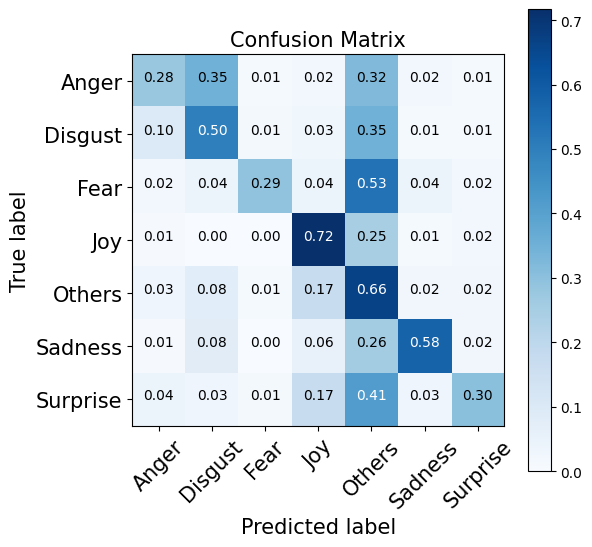

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix_decimals(cm, classes, ax,
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))

    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=15)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=15)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label', fontsize=15)
    ax.set_xlabel('Predicted label', fontsize=15)


result = results[0]
fig, ax = plt.subplots(figsize=(6, 6))
cm = result['confusion_matrix_results']
print(cm)
plot_confusion_matrix_decimals(cm, ['Anger', 'Disgust', 'Fear', 'Joy', 'Others', 'Sadness', 'Surprise'], ax)
plt.title('Confusion Matrix', fontsize=15)
plt.show()